# Fine Tuning a CNN

 We've written some of our own CNN's, let's look at what it takes to fine tune an existing one.


In [1]:
import torch
import seaborn as sns
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## We'll use the same CIFAR 10 Dataset as Before

In [2]:
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

Files already downloaded and verified


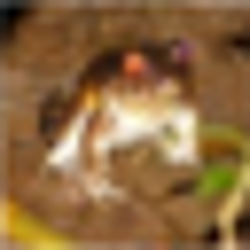

In [3]:
data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)
img,label=data[0]
display(img.resize((250,250)))

Reminder of the image sizes

In [4]:
np.asarray(img).shape

(32, 32, 3)

 There are a lot of existing models some are small, some are big, some work as classifiers others do object detection.
 * You'll needs to look them up to figure out what they are use for https://pytorch.org/vision/main/models.html


In [5]:
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import mobilenet_v3_small,MobileNet_V3_Small_Weights
print(torchvision.models.list_models())


['alexnet', 'convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'deeplabv3_mobilenet_v3_large', 'deeplabv3_resnet101', 'deeplabv3_resnet50', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m', 'efficientnet_v2_s', 'fasterrcnn_mobilenet_v3_large_320_fpn', 'fasterrcnn_mobilenet_v3_large_fpn', 'fasterrcnn_resnet50_fpn', 'fasterrcnn_resnet50_fpn_v2', 'fcn_resnet101', 'fcn_resnet50', 'fcos_resnet50_fpn', 'googlenet', 'inception_v3', 'keypointrcnn_resnet50_fpn', 'lraspp_mobilenet_v3_large', 'maskrcnn_resnet50_fpn', 'maskrcnn_resnet50_fpn_v2', 'maxvit_t', 'mc3_18', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'mvit_v1_b', 'mvit_v2_s', 'quantized_googlenet', 'quantized_inception_v3', 'quantized_mobilenet_v2

## ConvNeXT
"The ConvNeXT model was proposed in A ConvNet for the 2020s by Zhuang Liu, Hanzi Mao, Chao-Yuan Wu, Christoph Feichtenhofer, Trevor Darrell, Saining Xie. ConvNeXT is a pure convolutional model (ConvNet), inspired by the design of Vision Transformers, that claims to outperform them."

# Pretrained Weights

Most models come with pretrained weights, which are the weights the model has after being trained on a specific dataset and task.

In [6]:
model=torchvision.models.convnext_tiny(weights="IMAGENET1K_V1").to(device)

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /home/msuresh/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 324MB/s] 


## Important!!!

If you want to use pre-trained weights correctly, you'll need to use data that matches whatever was used to train that model
* Fortunately, torchvision model weights come with the transforms to use with them

In [7]:
transform=torchvision.models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1.transforms()


In [8]:
print(transform)

ImageClassification(
    crop_size=[224]
    resize_size=[236]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [9]:
#transform = transforms.Compose(
#    [transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

raw_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=None)


test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

cifar_lookup_dict={
    0 :'Plane',
    1 :'Car',
    2 :'Bird',
    3 :'Cat',
    4 :'Deer',
    5 :'Dog',
    6 :'Frog',
    7 :'Horse',
    8 :'Ship',
    9 :'Truck'}


Files already downloaded and verified


/packages/miniconda-t2/20230523/envs/jupyter-cuda121-20230610/lib/python3.8/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified
Files already downloaded and verified


In [10]:
imgs,labels = next(iter(train_loader))

In [11]:
print(imgs.shape)

torch.Size([64, 3, 224, 224])


In [12]:
print(model)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [13]:
print(model.classifier)

Sequential(
  (0): LayerNorm2d((768,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=768, out_features=1000, bias=True)
)


In [14]:
print(imgs.shape)

print(model(imgs.to(device)))

torch.Size([64, 3, 224, 224])
tensor([[ 0.5475,  0.9960, -0.5907,  ..., -0.2786, -0.5128, -1.2254],
        [-0.0154, -0.6286, -1.4316,  ..., -0.8927,  0.0141, -0.3079],
        [-0.3091, -0.4189, -0.9038,  ...,  0.8372, -1.6791,  0.1495],
        ...,
        [-0.3330, -0.2690, -1.1220,  ..., -1.3318, -0.6293, -0.8954],
        [-0.9122,  0.4815, -0.9290,  ..., -0.0055, -1.3176, -0.5906],
        [-0.5536,  0.6538, -1.7730,  ...,  0.1649,  1.0415, -0.6605]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


# Question 1

The weights I've loaded are from Imagenet 1,000 classes version 1 (IMAGENET1K_V1)

I would like to you tell me what it predicts for the first test image? (You'll need to make a prediction then look online)




In [15]:
first_imgs,first_labels = next(iter(test_loader))

In [17]:
with torch.no_grad():
    model.eval()
    out = model(first_imgs.to(device))
    print(torch.argmax(out, dim=1))

tensor([281, 891, 675, 147,  32, 286, 491, 653, 281, 675, 473, 675, 152, 375,
        675, 510, 215, 339, 510,  32, 339, 499, 335, 555, 193,   7, 167, 584,
        675,  32, 262, 154, 274, 262, 675, 381, 351, 675, 675, 154, 676,  32,
        152,  68, 856, 675, 186, 758, 339,  32, 675, 510, 449, 291, 510, 914,
        167, 676, 373, 763, 339, 374, 335, 789], device='cuda:0')


3


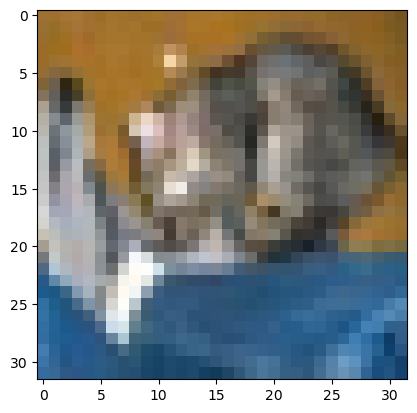

In [18]:
import matplotlib.pyplot as plt
plt.imshow(raw_testset[0][0])
print(raw_testset[0][1])

# Freezing Weights

* Fine tuning involves keeping most of the weights the same
* We can 'turn off' training for layers with the following loop 


In [21]:
for param in model.parameters():
        print(param)
        param.requires_grad = False



Parameter containing:
tensor([[[[-1.0185e-01, -1.2578e-01, -7.7726e-02, -4.8400e-02],
          [ 4.9147e-02, -5.8334e-03, -2.7219e-02,  7.3509e-03],
          [ 5.5126e-03, -1.6561e-02, -4.0036e-04, -1.0241e-02],
          [ 5.7510e-02,  6.3285e-02,  1.3278e-01,  1.2063e-01]],

         [[-1.5120e-02, -4.1978e-02, -2.4566e-03,  2.2013e-02],
          [ 8.1702e-02,  3.0936e-02,  1.8255e-02,  2.0605e-02],
          [-4.4677e-02, -4.6562e-02, -2.1829e-02, -6.8205e-02],
          [-2.6323e-02, -1.2427e-02,  5.4956e-02,  4.6793e-03]],

         [[ 4.6735e-02,  2.6825e-02,  7.6230e-02,  6.5599e-02],
          [ 8.1897e-02,  5.7258e-02,  4.0259e-02,  2.5218e-02],
          [-4.9520e-02, -4.2494e-02, -6.3224e-03, -8.3843e-02],
          [-8.0365e-02, -6.9506e-02,  5.9792e-03, -5.5452e-02]]],


        [[[ 2.3301e-02,  2.1222e-02,  4.5376e-02, -4.7012e-03],
          [ 1.0539e-03, -7.4608e-02,  6.7310e-02,  6.6184e-02],
          [-6.6223e-03, -7.0230e-04,  1.6563e-03, -1.6005e-02],
          

# Add Your Own Classifier Head

The 'head' of a CNN is the fully connect layers at the end of the model.
To fine tune it we can replace the  fully connected with a new one.

In [22]:
print(model.classifier[0])
print(model.classifier[1])
print(model.classifier[2])

model.classifier[2]=nn.Linear(in_features=768, out_features=10)

print([p.requires_grad  for p in model.classifier[2].parameters()])

LayerNorm2d((768,), eps=1e-06, elementwise_affine=True)
Flatten(start_dim=1, end_dim=-1)
Linear(in_features=768, out_features=1000, bias=True)
[True, True]


# Everything else is the same as before

In [23]:

cifar10_model = model.to(device)
criterion = nn.CrossEntropyLoss()
lr=1e-3
optimizer = optim.Adam( cifar10_model.parameters(),lr=lr,weight_decay=0)


In [24]:
from tqdm import tqdm

In [25]:
epochs=4

_loss_plot_train=[]
_loss_plot_test=[]

for epoch in range(epochs):
    cifar10_model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs =  cifar10_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    avg_loss = running_loss / len(train_loader.dataset)
    _loss_plot_train.append(avg_loss)
    
    with torch.no_grad():
        prediction,truth=zip(*[(cifar10_model(x.to(device)),y.to(device)) for x,y in test_loader])
        prediction=torch.cat(prediction,dim=0)
        truth=torch.cat(truth,dim=0)
        val_loss=criterion(prediction, truth)
        _loss_plot_test.append(val_loss.item())
    
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f} Val Loss: {val_loss:.4f}")

100%|██████████| 782/782 [04:53<00:00,  2.67it/s]


Epoch [1/4] - Loss: 0.3342 Val Loss: 0.2445


100%|██████████| 782/782 [04:53<00:00,  2.67it/s]


Epoch [2/4] - Loss: 0.2049 Val Loss: 0.2157


100%|██████████| 782/782 [04:53<00:00,  2.66it/s]


Epoch [3/4] - Loss: 0.1866 Val Loss: 0.2092


100%|██████████| 782/782 [04:53<00:00,  2.66it/s]


Epoch [4/4] - Loss: 0.1782 Val Loss: 0.2084


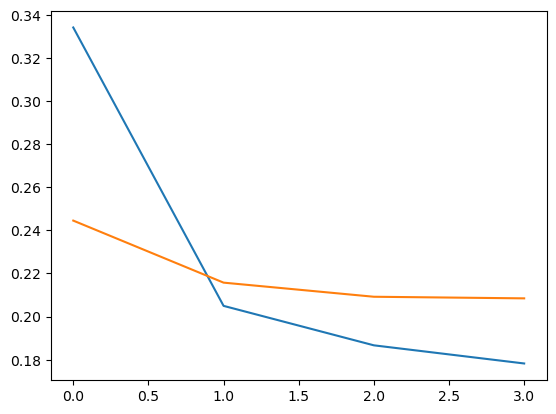

In [26]:
import matplotlib.pyplot as plt
plt.plot(_loss_plot_train)
plt.plot(_loss_plot_test)
plt.show()

In [27]:
with torch.no_grad():
    cifar10_model.eval()
    prediction,truth=zip(*[(torch.softmax(cifar10_model(x.to(device)),axis=1),y) for x,y in test_loader])

prediction=torch.cat(prediction,dim=0).cpu().numpy()
truth=torch.cat(truth,dim=0).cpu().numpy()
predicted_labels=np.argmax(prediction,axis=1)

In [28]:
print("Accuracy",(predicted_labels==truth).mean())

Accuracy 0.9369


<Axes: >

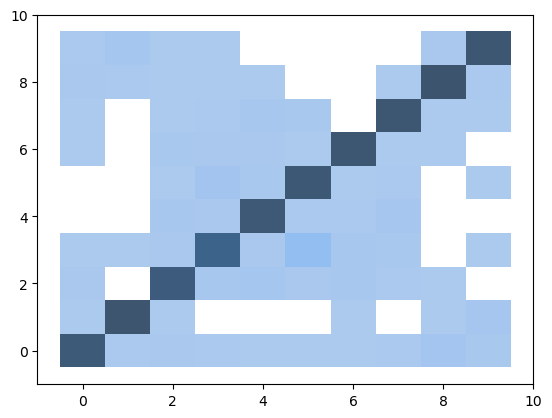

In [29]:
sns.histplot(x=predicted_labels,y=truth,discrete=True,bins=20)

----------------- 2405 -----------------
Predicted Probability 1.00 Class 6 Frog
True Class 3 Cat
-2.117904
(3, 224, 224)


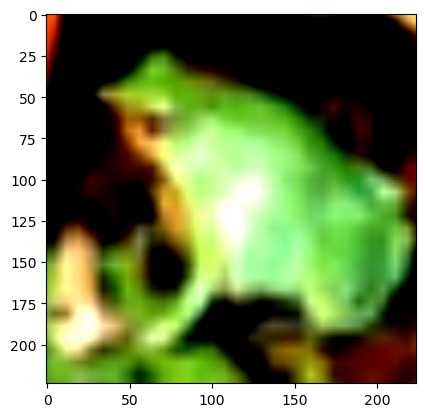

----------------- 2495 -----------------
Predicted Probability 1.00 Class 8 Ship
True Class 9 Truck
-1.8096584
(3, 224, 224)


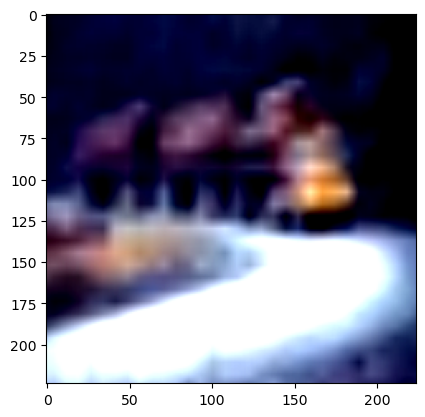

----------------- 5806 -----------------
Predicted Probability 1.00 Class 8 Ship
True Class 0 Plane
-1.6041614
(3, 224, 224)


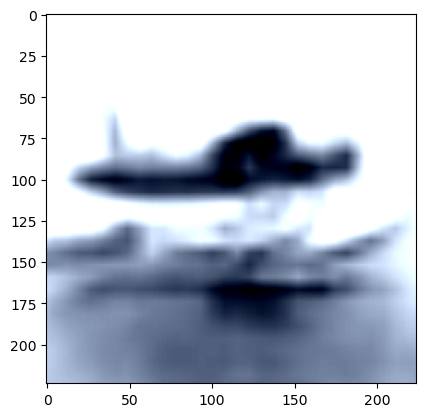

----------------- 4163 -----------------
Predicted Probability 1.00 Class 6 Frog
True Class 2 Bird
-1.9131652
(3, 224, 224)


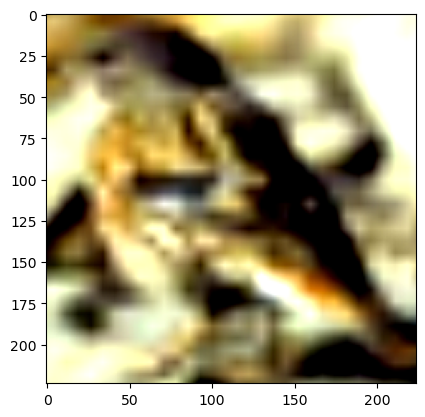

----------------- 9528 -----------------
Predicted Probability 1.00 Class 8 Ship
True Class 0 Plane
-1.6212862
(3, 224, 224)


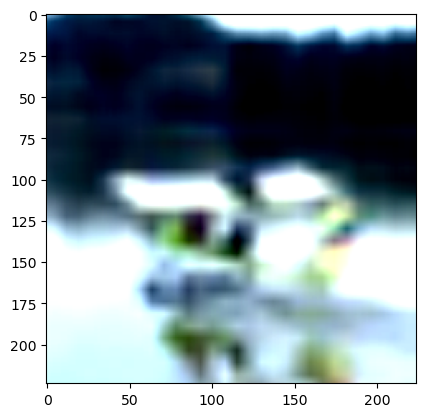

----------------- 5548 -----------------
Predicted Probability 1.00 Class 0 Plane
True Class 8 Ship
-1.7582842
(3, 224, 224)


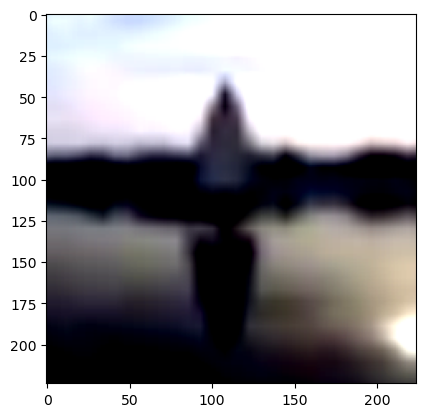

----------------- 1180 -----------------
Predicted Probability 1.00 Class 5 Dog
True Class 3 Cat
-2.117904
(3, 224, 224)


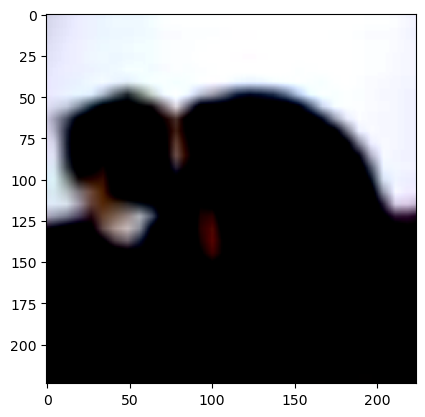

----------------- 2854 -----------------
Predicted Probability 1.00 Class 1 Car
True Class 9 Truck
-1.9980307
(3, 224, 224)


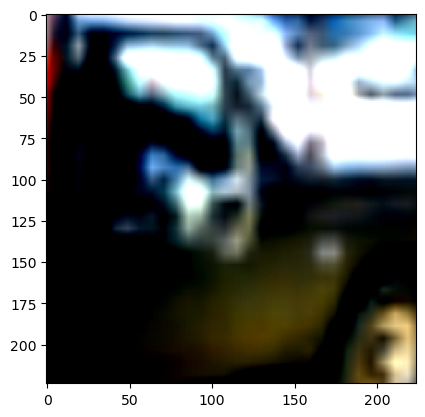

----------------- 3094 -----------------
Predicted Probability 1.00 Class 0 Plane
True Class 2 Bird
-1.7380952
(3, 224, 224)


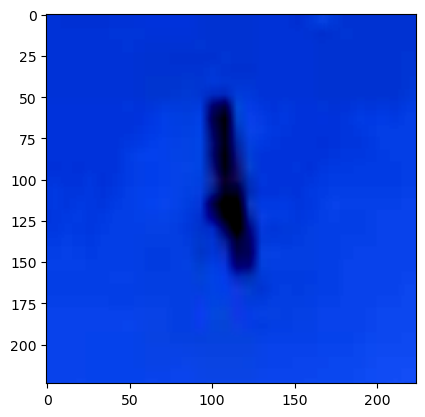

----------------- 3450 -----------------
Predicted Probability 0.99 Class 1 Car
True Class 9 Truck
-1.8952821
(3, 224, 224)


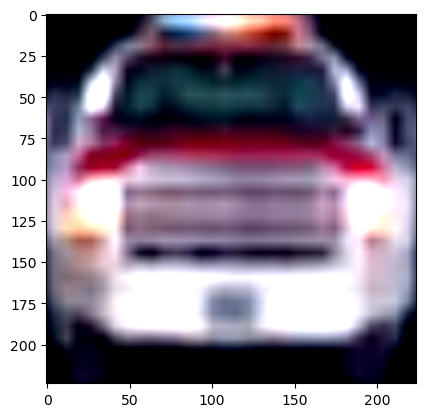

In [30]:
import matplotlib.pyplot as plt
wrong= (predicted_labels != truth)
sorted_prediction=np.flip(np.argsort(prediction.max(axis=1)))

worst_predictions= [i for i in sorted_prediction if wrong[i]]

for index in worst_predictions[0:10]:
    
    print("-----------------",index,"-----------------")
    print(f"Predicted Probability {prediction[index].max().item():.2f}", 'Class' ,predicted_labels[index], cifar_lookup_dict[predicted_labels[index]])
    print("True Class",truth[index], cifar_lookup_dict[truth[index]])
    _plot_img=testset[index][0].numpy()
    
    print(np.min(_plot_img))
    print(_plot_img.shape)
    _plot_img=(np.clip((_plot_img.transpose((1,2,0))+1)/2,0,1)*255) .astype('uint8')
    plt.imshow(_plot_img)
    plt.show()
    

# Exercise Everyone

Trying to fine tune a different model from the list of classification models here:
https://pytorch.org/vision/main/models.html

1. Main goal is to get a model training
2. Replacing the 'head' of each model will be a little bit different each time

In [37]:
num_classes = 10
model = torchvision.models.convnext_tiny(weights="IMAGENET1K_V1")

model.classifier[2] = nn.Linear(model.classifier[2].in_features, num_classes)
model = models.resnet50(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, num_classes)

transform = models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1.transforms()

from torchvision import datasets
from torch.utils.data import DataLoader

trainset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
test_loader = DataLoader(testset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
criterion = nn.CrossEntropyLoss()
lr=1e-3
optimizer = optim.Adam( cifar10_model.parameters(),lr=lr,weight_decay=0)

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

epochs = 4
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")

Epoch [1/4], Loss: 0.9723


In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# 510-Excercise "Deep Dreams"

This is a fun example for visualing CNN's, for this example I would like you:

1. Look at https://research.google/blog/inceptionism-going-deeper-into-neural-networks
2. I would like you create a fun picture by adjusting the hyperparameters below and finding something you like 
3. I would like you to replace the **TODO: Comment** with your own explination of what's going on


In [343]:

dream_model=torchvision.models.convnext_tiny(weights="IMAGENET1K_V1").to(device)
dream_model.eval()

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [374]:
#TODO: Comment

scale=0.1
trainable_input_image=torch.nn.parameter.Parameter(data=torch.randn(1,3,224,224).to(device)*scale)
optimizer=optim.Adam([trainable_input_image],lr=.1)

def image_correlation_loss(img):
    #Real images have neaby pixels correlated this function returns the mean distance between neighboring pixels
    horizontal=torch.linalg.norm(img[0,:,1:,:]-img[0,:,:-1,:],dim=0).mean()
    vertical=torch.linalg.norm(img[0,:,:,1:]-img[0,:,:,:-1],dim=0).mean()
    return horizontal+vertical

#TODO: Comment
c_beta=5
l2_beta=1e-2



  0%|          | 0/4001 [00:00<?, ?it/s]

Loss 2.754666328430176
Class Prob 0.00041011639405041933 class_loss 0.508691132068634


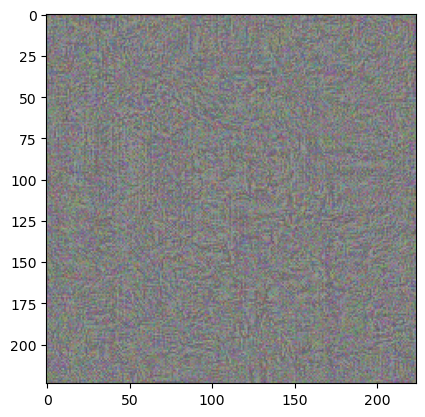

 12%|█▏        | 498/4001 [00:15<01:49, 32.06it/s]

Loss -27.533245086669922
Class Prob 1.0 class_loss -30.168954849243164


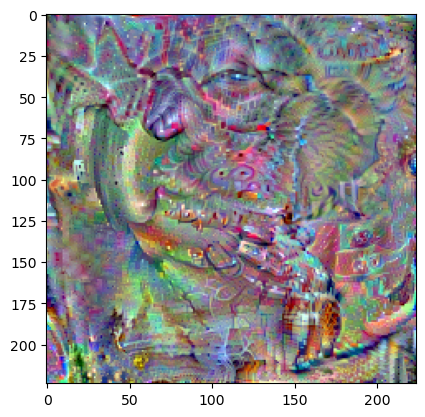

 25%|██▍       | 998/4001 [00:31<01:33, 32.07it/s]

Loss -27.63050079345703
Class Prob 1.0 class_loss -30.140247344970703


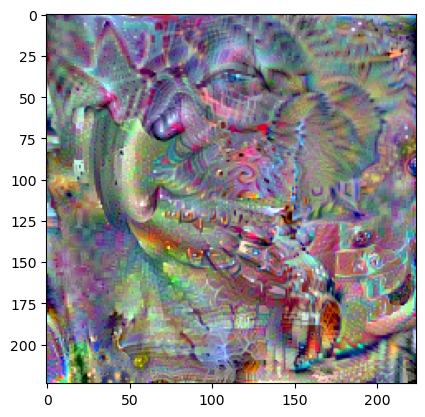

 37%|███▋      | 1498/4001 [00:47<01:18, 32.07it/s]

Loss -25.563926696777344
Class Prob 1.0 class_loss -30.564611434936523


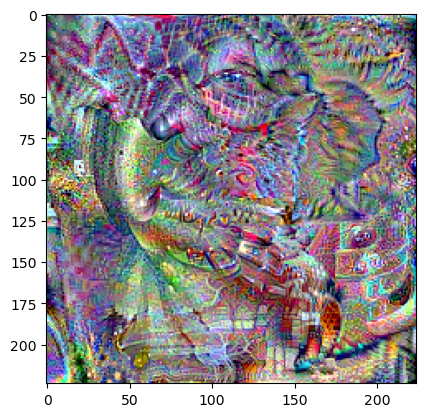

 41%|████▏     | 1658/4001 [00:52<01:13, 32.07it/s]

In [ ]:
#TODO: Pick a class
class_id=504

for i in tqdm(range(4001)):

    #TODO: Comment
#    features=dream_model.features(trainable_input_image)[:,:,3:4,3:4] # The indexing here tells us where int the image we'll optimize
    features=dream_model.features(trainable_input_image)# The is everywhere
    avg_pool=dream_model.avgpool(features)
    out=dream_model.classifier(avg_pool)

    #TODO: Comment
    class_logit=out[:,class_id]
    class_prob=torch.nn.functional.softmax(out,dim=1)[:,class_id]
    logit_l2=torch.linalg.norm(out,dim=1)
    class_loss=-1*class_logit+l2_beta*logit_l2
     
    #TODO: Comment
    image_coherence_loss=image_correlation_loss(trainable_input_image)
    loss=class_loss+c_beta*image_coherence_loss

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    #TODO: Comment
    with torch.no_grad():
        trainable_input_image.clamp(-1,1)
        
    if i % 500 ==0:
        #TODO: Comment
        print('Loss',loss.item())
        print('Class Prob',class_prob.item(),'class_loss',class_loss.item())
        np_img=trainable_input_image[0].permute(1,2,0).detach().cpu().numpy()
        np_img= np.clip(np_img,-1,1)
        np_img=(np_img+1)/2
        plt.imshow(np_img)
        plt.show()

# Run the below for your favorite image!

torch.Size([1, 768, 7, 7])

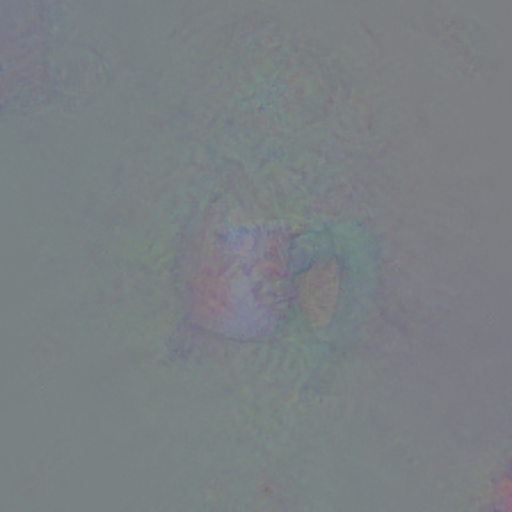

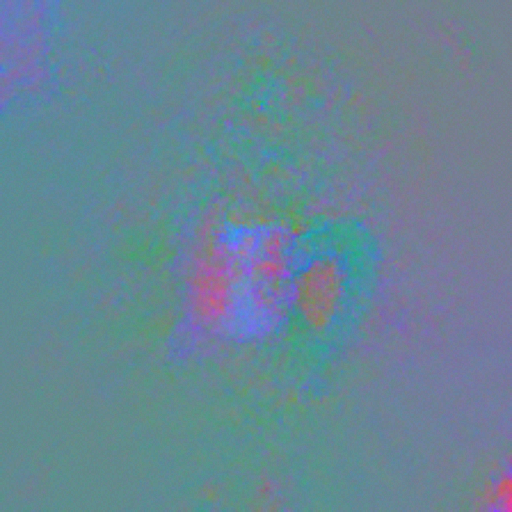

In [369]:
from PIL import Image,ImageEnhance
c = Image.fromarray((np_img*255).astype('uint8') )
d = c.resize((512,512), resample=Image.BILINEAR)
display(d)

enhancer = ImageEnhance.Color(d)
# Adjust the color balance
# factor > 1.0 increases saturation, < 1.0 decreases saturation
enhanced_image = enhancer.enhance(5)
display(enhanced_image)